In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import dates
from datetime import datetime
import sklearn
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [2]:
walmart_data = pd.read_csv("/content/Walmart (1).csv")
walmart_data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
# Convert date to datetime format
walmart_data['Date'] =  pd.to_datetime(walmart_data['Date'])
walmart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


<ipython-input-3-28dfce835161>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  walmart_data['Date'] =  pd.to_datetime(walmart_data['Date'])


In [4]:
#Checking for missing values
walmart_data.isnull().sum()


Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [5]:
walmart_data["Day"]= pd.DatetimeIndex(walmart_data['Date']).day
walmart_data['Month'] = pd.DatetimeIndex(walmart_data['Date']).month
walmart_data['Year'] = pd.DatetimeIndex(walmart_data['Date']).year
walmart_data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,2,5,2010
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,2,12,2010
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,19,2,2010
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,26,2,2010
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,3,5,2010
...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,28,9,2012
6431,45,2012-05-10,733455.07,0,64.89,3.985,192.170412,8.667,10,5,2012
6432,45,2012-12-10,734464.36,0,54.47,4.000,192.327265,8.667,10,12,2012
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,19,10,2012


In [ ]:
#Which store has maximum sales ?

<Axes: title={'center': 'Total sales for each store'}, xlabel='Store', ylabel='Total Sales'>

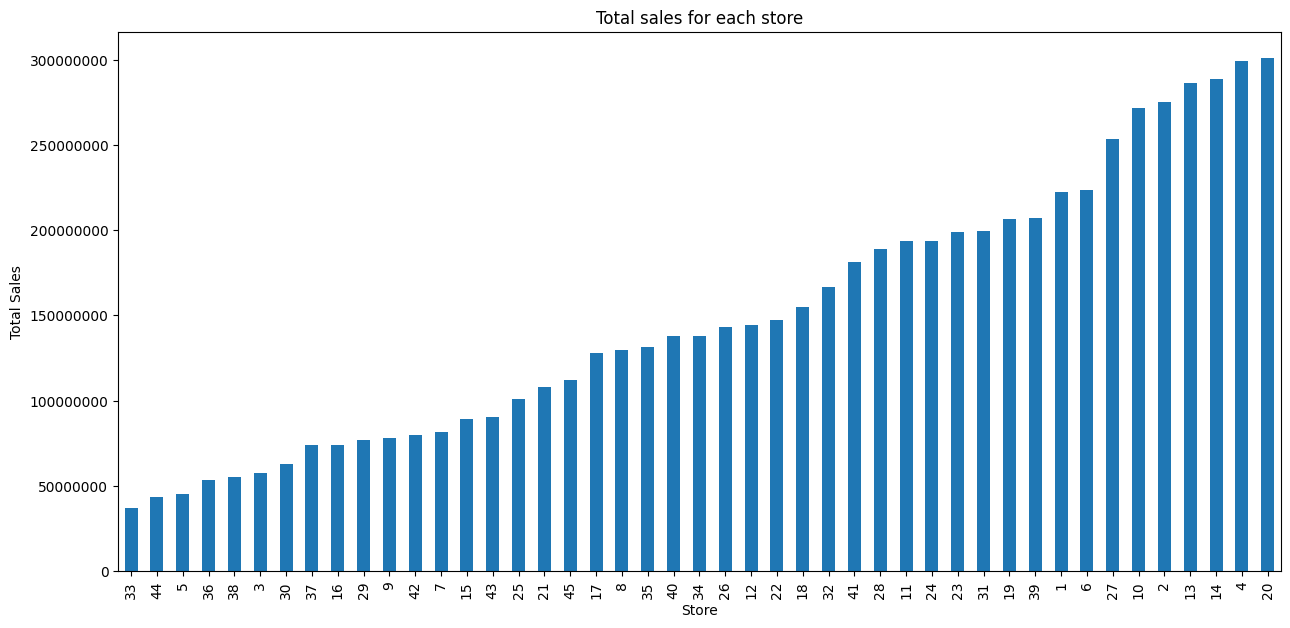

In [6]:
total_sales= walmart_data.groupby('Store')['Weekly_Sales'].sum().sort_values()
total_sales_array = np.array(total_sales)
plt.figure(figsize=(15,7))
plt.xticks(rotation=0)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Total sales for each store')
plt.xlabel('Store')
plt.ylabel('Total Sales')
total_sales.plot(kind='bar')

In [ ]:
#Which store has maximum standard deviation? i.e. the sales vary a lot. Also, find out the coefficient of mean to standard deviation.

In [7]:
walmart_data_std = pd.DataFrame(walmart_data.groupby('Store')['Weekly_Sales'].std().sort_values(ascending=False))
walmart_data_std.head(1).index[0] , walmart_data_std.head(1).Weekly_Sales[walmart_data_std.head(1).index[0]]


(14, 317569.9494755081)

In [ ]:
#Thus, the store which has maximum standard deviation is store number 14.

<ipython-input-8-d383728a8148>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(walmart_data[walmart_data['Store'] == walmart_data_std.head(1).index[0]]['Weekly_Sales'])


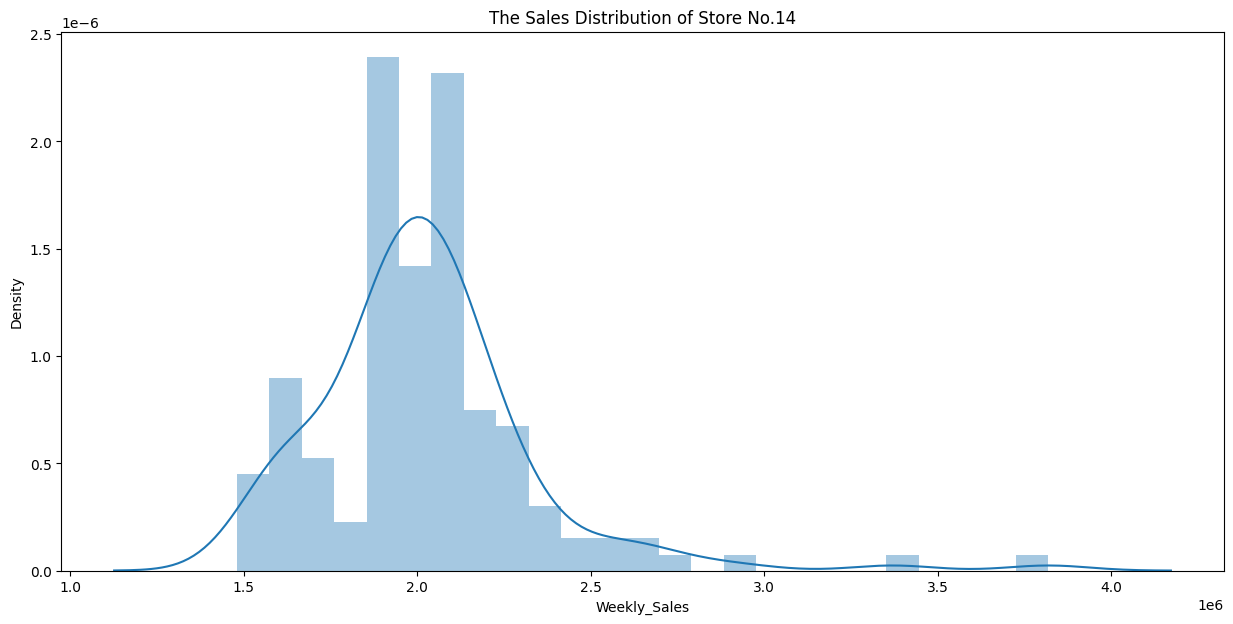

In [8]:
# Extracting the sales data for store number 14 and plotting its distribution
plt.figure(figsize=(15,7))
sns.distplot(walmart_data[walmart_data['Store'] == walmart_data_std.head(1).index[0]]['Weekly_Sales'])
plt.title('The Sales Distribution of Store No.'+ str(walmart_data_std.head(1).index[0]))
import warnings
warnings.filterwarnings('ignore')

In [9]:
#Calculating the coefficient of mean to standard deviation
coef = pd.DataFrame(walmart_data.groupby('Store')['Weekly_Sales'].std() / walmart_data.groupby('Store')['Weekly_Sales'].mean())
coef = coef.rename(columns={'Weekly_Sales':'Coefficient of mean to standard deviation'})
coef_max = coef.sort_values(by='Coefficient of mean to standard deviation',ascending=False)
coef_max.head(7)

,Coefficient of mean to standard deviation
Store,
35,0.229681
7,0.197305
15,0.193384
29,0.183742
23,0.179721
21,0.170292
45,0.165613


In [ ]:
#Thus, the store which has maximum coefficient of mean to standard deviation is store number 35.

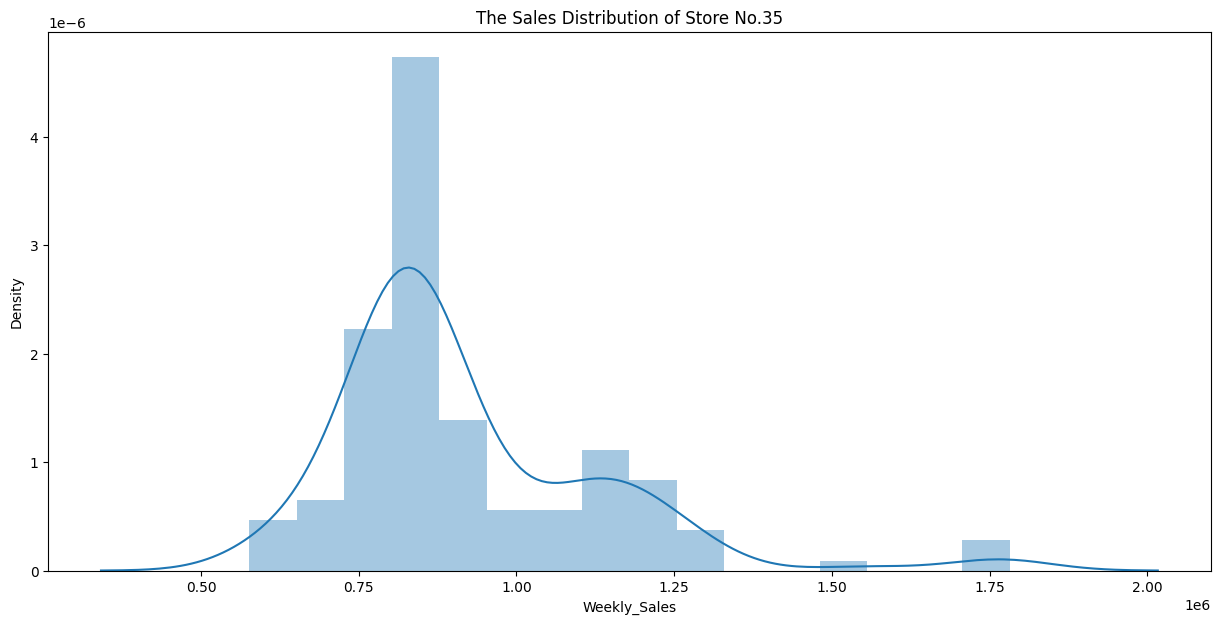

In [10]:
# Distribution of store 35 has maximum coefficient of mean to standard deviation
plt.figure(figsize=(15,7))
sns.distplot(walmart_data[walmart_data['Store'] == coef_max.head(1).index[0]]['Weekly_Sales'])
plt.title('The Sales Distribution of Store No.'+str(coef_max.head(1).index[0]))
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Provide a monthly and semester view of sales in units and give insights.

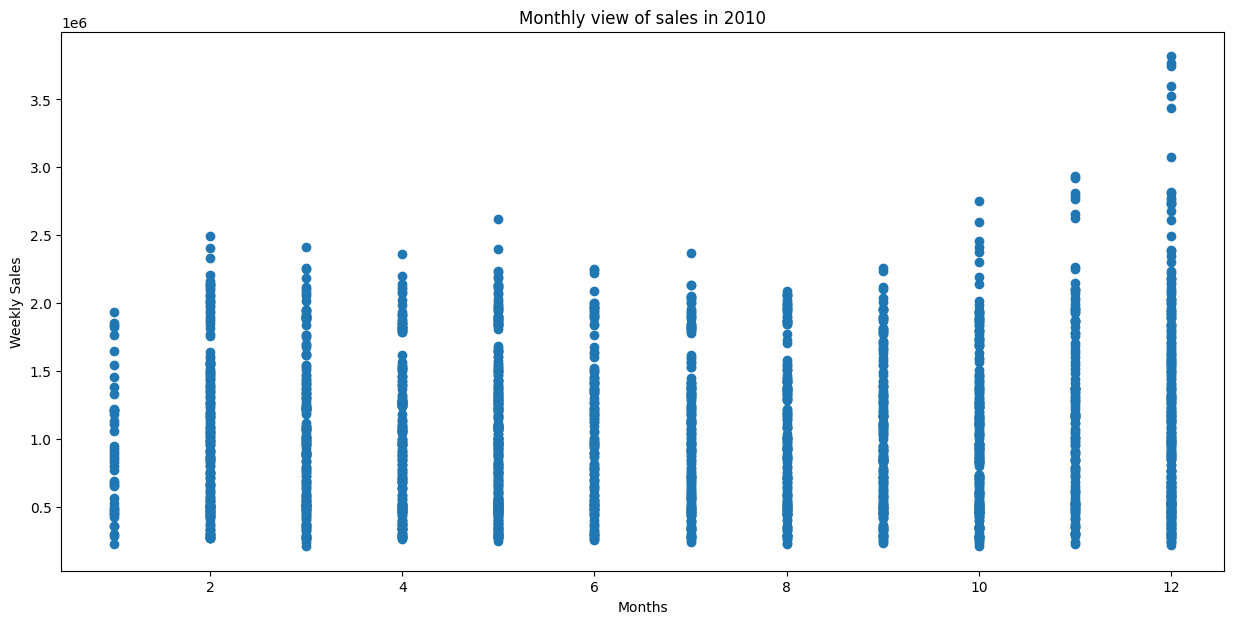

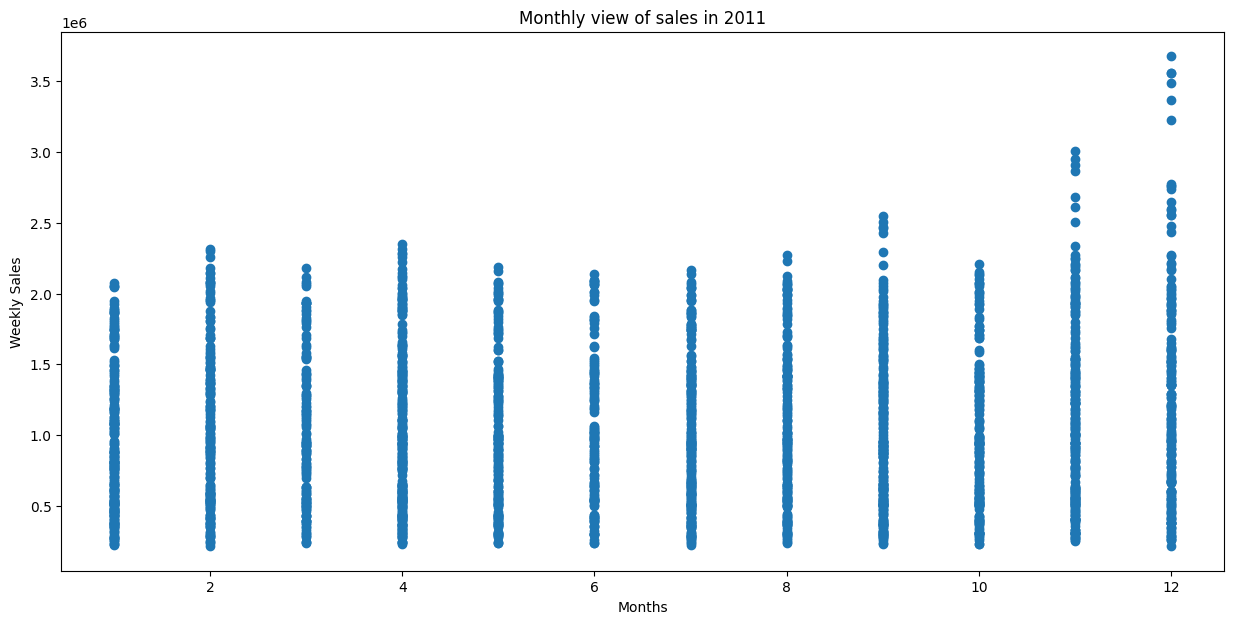

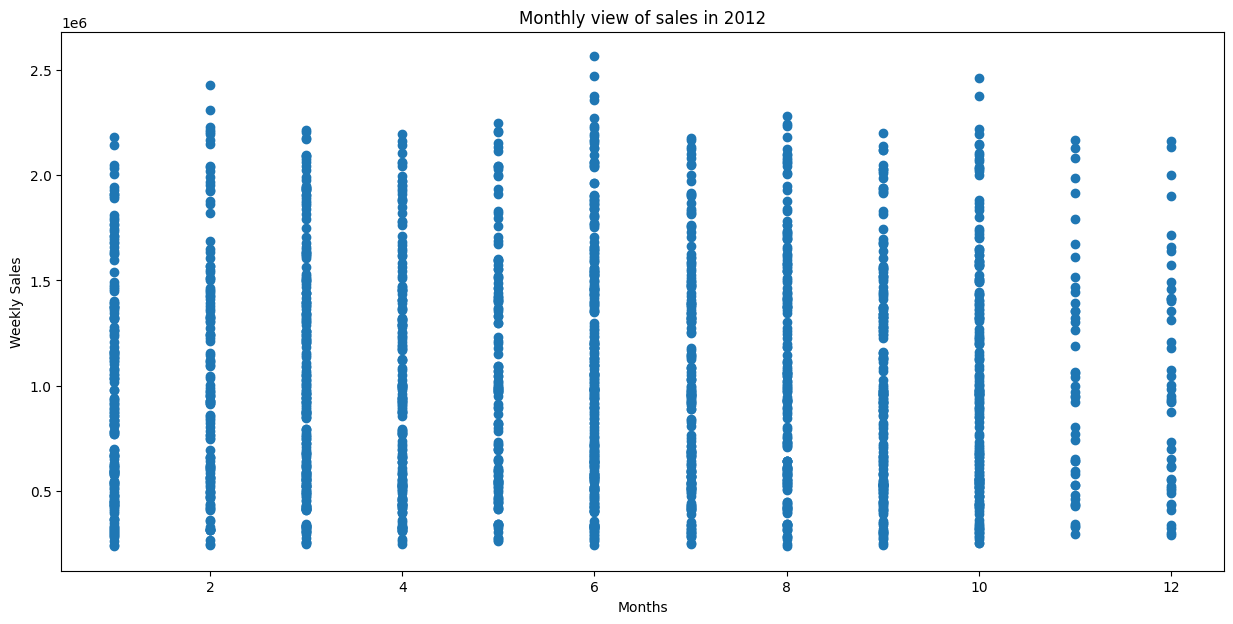

In [11]:
plt.figure(figsize=(15,7))
plt.scatter(walmart_data[walmart_data.Year==2010]["Month"],walmart_data[walmart_data.Year==2010]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2010")
plt.show()

plt.figure(figsize=(15,7))
plt.scatter(walmart_data[walmart_data.Year==2011]["Month"],walmart_data[walmart_data.Year==2011]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2011")
plt.show()

plt.figure(figsize=(15,7))
plt.scatter(walmart_data[walmart_data.Year==2012]["Month"],walmart_data[walmart_data.Year==2012]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2012")
plt.show()

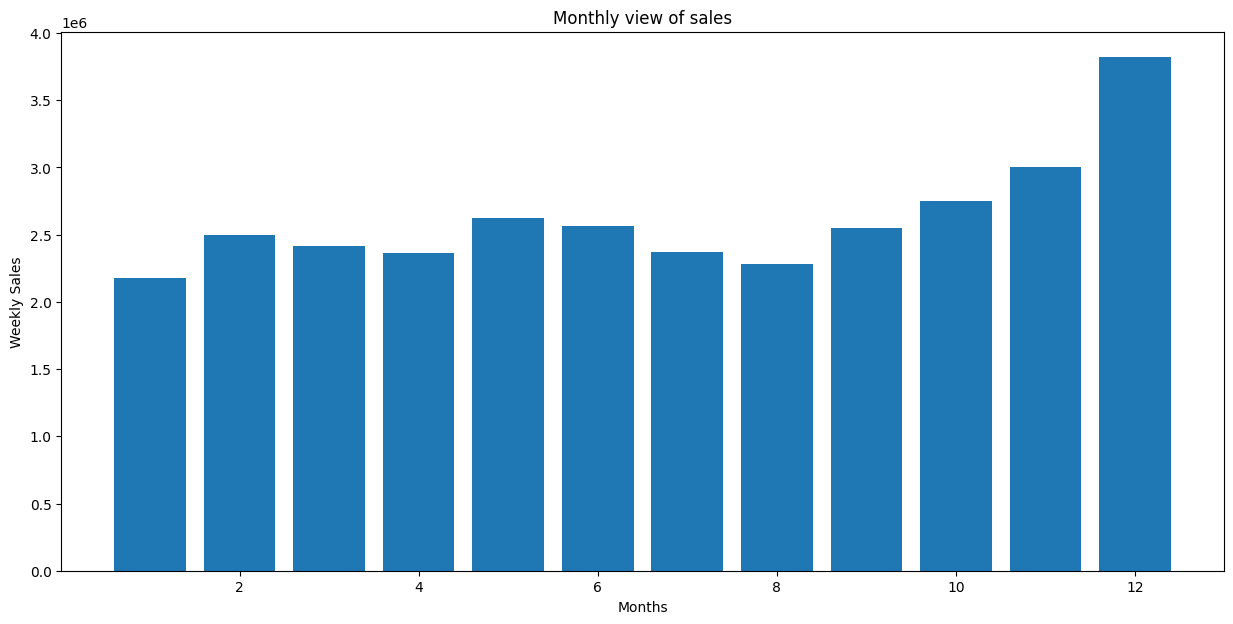

In [12]:
#Overall Monthly Sales
plt.figure(figsize=(15,7))
plt.bar(walmart_data["Month"],walmart_data["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales")
plt.show()

<Figure size 1500x700 with 0 Axes>

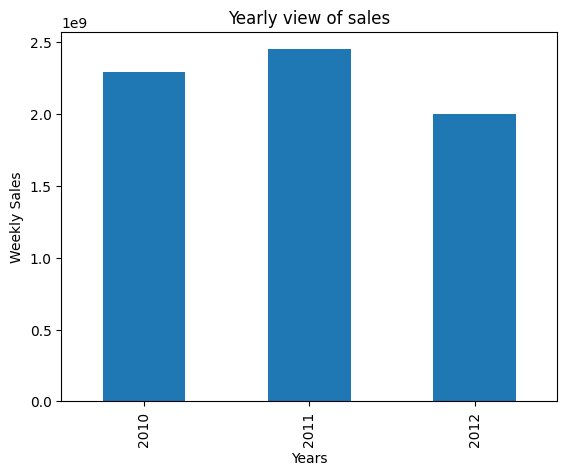

In [14]:
#Yearly Sales
plt.figure(figsize=(15,7))
walmart_data.groupby("Year")[["Weekly_Sales"]].sum().plot(kind='bar',legend=False)
plt.xlabel("Years")
plt.ylabel("Weekly Sales")
plt.title("Yearly view of sales")
plt.show()

In [ ]:
#Here, overall monthly sales are higher in the month of December while the yearly sales in the year 2011 are the highest.

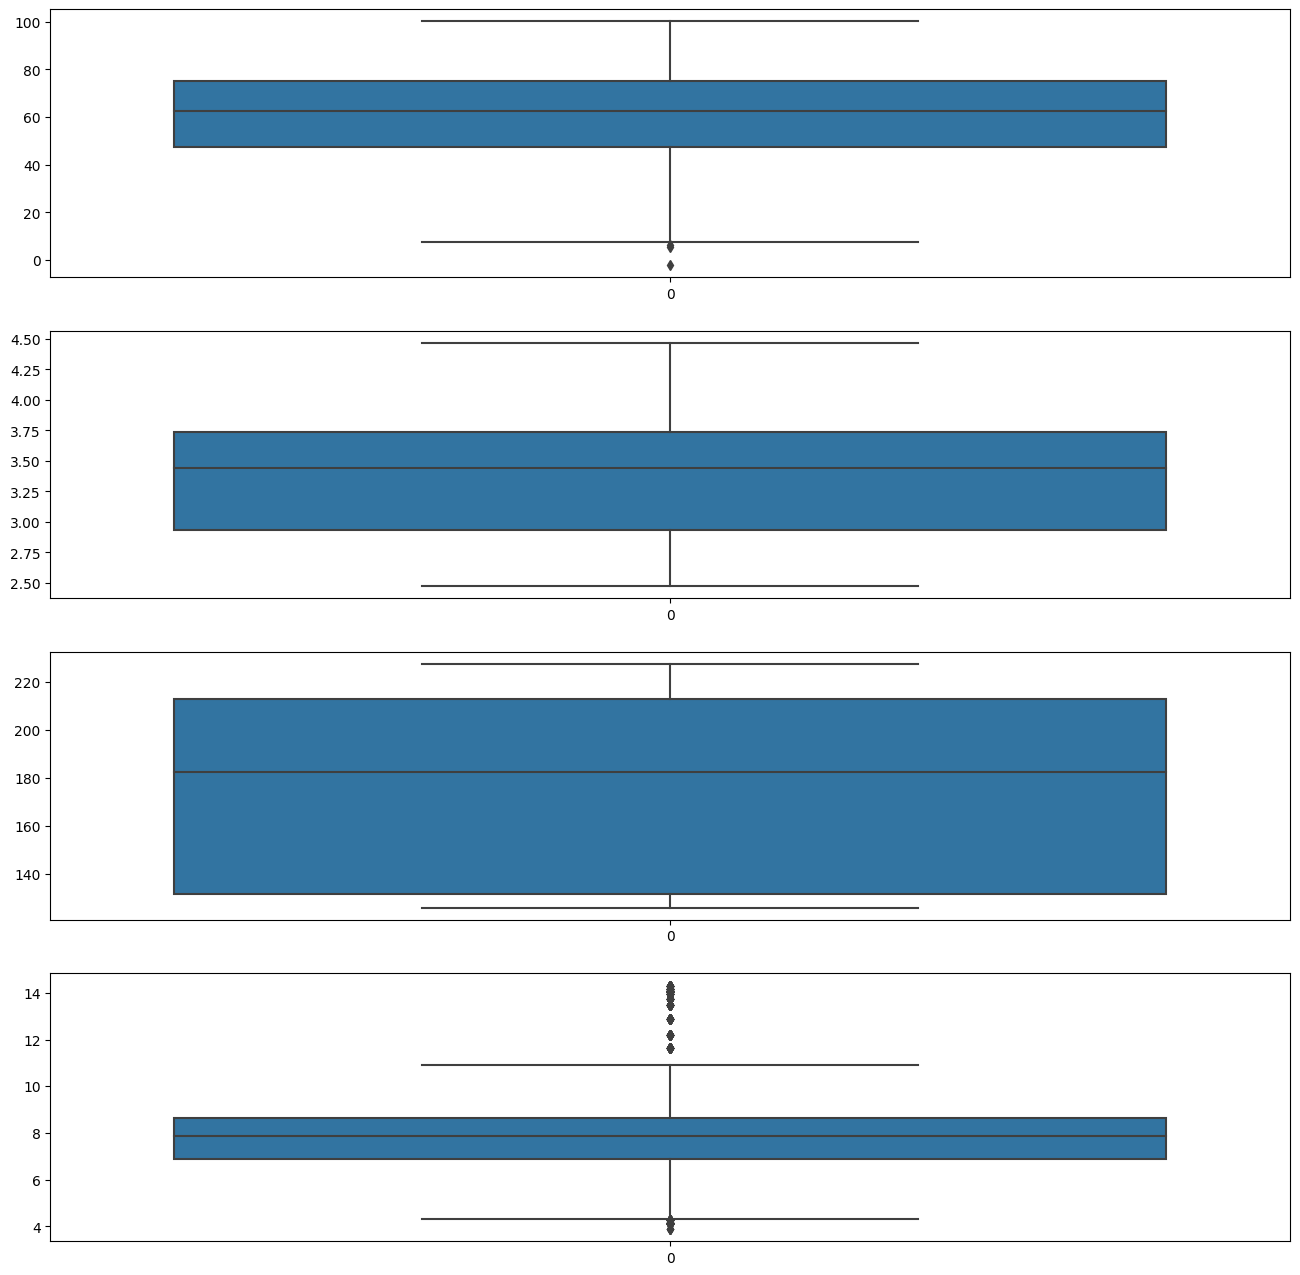

In [15]:
#Detecting outliers :
fig, axis = plt.subplots(4,figsize=(16,16))
X = walmart_data[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(walmart_data[column],ax=axis[i])

import warnings
warnings.filterwarnings('ignore')

In [16]:
# Dropping outliers
walmart_data_clean = walmart_data[(walmart_data['Unemployment']<10) & (walmart_data['Unemployment']>4.5) & (walmart_data['Temperature']>10)]
walmart_data_clean

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,2,5,2010
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,2,12,2010
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,19,2,2010
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,26,2,2010
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,3,5,2010
...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,28,9,2012
6431,45,2012-05-10,733455.07,0,64.89,3.985,192.170412,8.667,10,5,2012
6432,45,2012-12-10,734464.36,0,54.47,4.000,192.327265,8.667,10,12,2012
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,19,10,2012


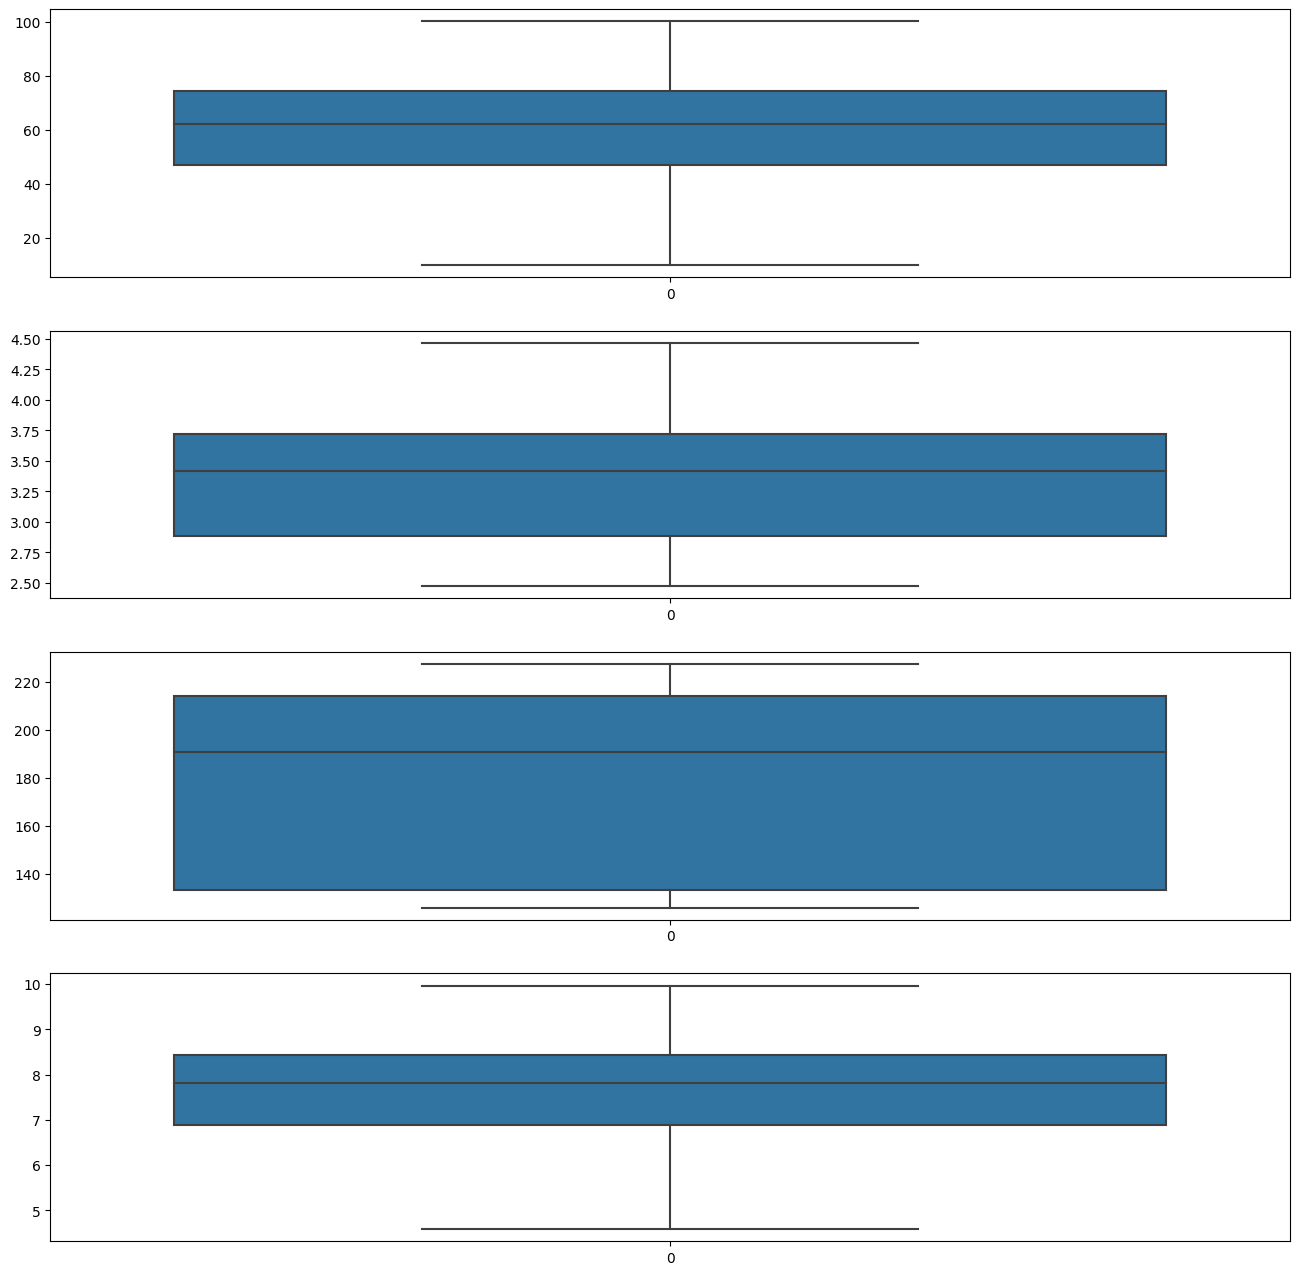

In [ ]:
#Checking data for outliers
fig, axis = plt.subplots(4,figsize=(16,16))
X = walmart_data_clean[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(walmart_data_clean[column], ax=axis[i])

import warnings
warnings.filterwarnings('ignore')

In [17]:
# Linear Regression :
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
X = walmart_data_clean[['Store','Fuel_Price','CPI','Unemployment','Day','Month','Year']]
Y = walmart_data_clean['Weekly_Sales']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

In [18]:
print('Linear Regression:')
print()
reg = LinearRegression()
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
print('Accuracy:',reg.score(X_train, Y_train)*100)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))


import warnings
warnings.filterwarnings('ignore')

Linear Regression:

Accuracy: 13.463829215139544
Mean Absolute Error: 460651.3991472611
Mean Squared Error: 309478003951.818
Root Mean Squared Error: 556307.472493241


In [19]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
print('Random Forest Regressor:')
print()
rfr = RandomForestRegressor()
rfr.fit(X_train,Y_train)
Y_pred = rfr.predict(X_test)
print('Accuracy:',rfr.score(X_test, Y_test)*100)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))



import warnings
warnings.filterwarnings('ignore')

Random Forest Regressor:

Accuracy: 94.14449372267669
Mean Absolute Error: 72062.57208674912
Mean Squared Error: 20249607723.313282
Root Mean Squared Error: 142301.11638112078


In [ ]:
###Here, Linear Regression is not an appropriate model to use which is clear from it's low accuracy. However, Random Forest Regression gives accuracy of over 95% , so, it is the best model to forecast demand.

In [ ]:
#Forecasting

In [35]:
# Train-Test Split
train_size = int(len(walmart_data) * 0.8)
train, test = walmart_data[:train_size], walmart_data[train_size:]

In [40]:
# SARIMAX Modeling
order = (1, 1, 1)  # Adjust order based on your data
seasonal_order = (1, 1, 1, 12)  # Adjust seasonal order based on your data


In [42]:
# Assume 'unemployment_rate' is an exogenous variable
exog_features = train[['Unemployment']]

In [43]:
# Fit the SARIMAX model
model_sarimax = SARIMAX(train['Weekly_Sales'], order=order, seasonal_order=seasonal_order, exog=exog_features)
results_sarimax = model_sarimax.fit(disp=False)

In [47]:
# Forecast for the next 12 weeks
forecast_steps = 12
exog_forecast = walmart_data[['Unemployment']].tail(forecast_steps)

# Ensure the shape is correct for the exogenous variable
exog_forecast = exog_forecast.values.reshape(-1, 1)

# Forecast using the fitted model
forecast_sarimax = results_sarimax.get_forecast(steps=forecast_steps, exog=exog_forecast)
forecast_mean_sarimax = forecast_sarimax.predicted_mean




In [49]:
# Evaluate the SARIMAX model
mae_sarimax = mean_absolute_error(test['Weekly_Sales'][:forecast_steps], forecast_mean_sarimax)
print(f'Mean Absolute Error (SARIMAX): {mae_sarimax}')

Mean Absolute Error (SARIMAX): 249216.21613907022


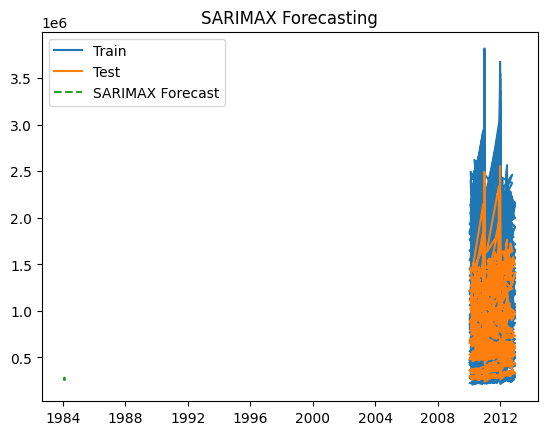

In [50]:
# Visualize the SARIMAX results
plt.plot(train['Date'], train['Weekly_Sales'], label='Train')
plt.plot(test['Date'], test['Weekly_Sales'], label='Test')
plt.plot(forecast_mean_sarimax.index, forecast_mean_sarimax.values, label='SARIMAX Forecast', linestyle='--')
plt.legend()
plt.title('SARIMAX Forecasting')
plt.show()